In [80]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/eos/home-g/gkrzmanc/mlpf_data")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep

hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)

In [81]:
# This block is the same as 1_dataset.ipynb

datasets = os.listdir("/eos/user/m/mgarciam/datasets_mlpf/230923_20_25")
#dataset = "/eos/user/g/gkrzmanc/ClicDet_v1_25_07_2023_full.root"

def remove_from_list(lst):
    out = []
    for item in lst:
        if item in ["hgcal", "data.txt", "test_file.root"]:
            continue
        out.append(item)
    return out

datasets = [os.path.join("/eos/user/m/mgarciam/datasets_mlpf/230923_20_25", x) for x in remove_from_list(datasets)]

class Args:
    def __init__(self):
        self.data_train = datasets
        self.data_val = datasets
        #self.data_train = files_train
        self.data_config = '/eos/home-g/gkrzmanc/mlpf_data/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                               extra_selection=args.extra_selection,
                               remake_weights=True,
                               load_range_and_fraction=(train_range, args.data_fraction),
                               file_fraction=args.file_fraction,
                               fetch_by_files=args.fetch_by_files,
                               fetch_step=args.fetch_step,
                               infinity_mode=False,
                               in_memory=args.in_memory,
                               async_load=False,
                               name='train')

In [82]:
iterator = iter(train_data)
g, gt = next(iterator)
g
g.ndata['particle_number'].unique()
gt
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)
iterator = iter(train_loader)


=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===


In [83]:
g, y = next(iterator)
y.shape
y

tensor([[ 2.7099e-01, -8.2326e-01,  4.9881e-01,  2.1475e+01,  2.1475e+01,
          5.4690e-03, -2.2120e+03],
        [-2.1946e-01, -7.5957e-01,  6.1228e-01,  3.4200e+01,  3.4197e+01,
          4.9760e-01,  1.3000e+02],
        [-3.9596e-02, -7.3885e-01, -6.7271e-01,  3.8397e+01,  3.8385e+01,
          9.3950e-01,  2.1120e+03],
        [-7.6420e-02,  9.9413e-01,  7.6551e-02,  3.1700e+01,  3.1686e+01,
          9.3826e-01,  2.2120e+03],
        [ 9.6467e-03,  3.5859e-02,  9.9931e-01,  2.2587e+01,  2.2581e+01,
          4.9759e-01,  1.3000e+02],
        [-1.3141e-01,  8.3531e-01, -5.3385e-01,  2.1710e+01,  2.1709e+01,
          1.3967e-01,  2.1100e+02],
        [-2.8815e-02,  6.9876e-01,  7.1478e-01,  3.4765e+01,  3.4752e+01,
          9.3959e-01,  2.1120e+03],
        [-2.9154e-02, -7.4442e-02, -9.9680e-01,  2.4798e+01,  2.4798e+01,
          1.3961e-01,  2.1100e+02],
        [-1.3688e-01, -9.8940e-01, -4.8565e-02,  2.5533e+01,  2.5515e+01,
          9.3828e-01,  2.2120e+03],
        [-

In [84]:
ht = g.ndata["hit_type"]
ht[ht[:, 2]==1]

tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0]])

In [85]:
#print(g.ndata["e_hits"].flatten())
#print(g.ndata["h"][:, 7])
hit_energies = g.ndata["e_hits"].flatten()
part_idx = g.ndata["particle_number"]
energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)[1:]
y_energy = y[:, 3]
#print(y_energy)

In [86]:
fracs1 = energy_from_showers/y_energy
print(fracs1)

tensor([0.8610, 0.8014, 0.9512, 0.9312, 1.0946, 1.0401, 0.9257, 0.7736, 0.8627,
        0.9677, 1.0867, 0.9457])


In [87]:
low_frac_particles = np.where(fracs1 < 0.05)[0] + 1
print(low_frac_particles)
low_frac_part_idx = []
for i in range(len(part_idx)):
    #print(part_idx[i])
    if part_idx[i].item() in low_frac_particles:
        low_frac_part_idx.append(i)
print(low_frac_part_idx)

[]


TypeError: 'tuple' object is not callable

In [ ]:
g.ndata["hit_type"].argmax(dim=1)

In [ ]:
# Plot an event example - to show how highly granular the calorimeter is
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
xhits, yhits, zhits = g.ndata["h"][:, 0], g.ndata["h"][:, 1], g.ndata["h"][:, 2]
color = g.ndata["particle_number"]
color_hittype = g.ndata["hit_type"].argmax(dim=1)
color_ht1 = []
for i in color_hittype:
    if i == 2:
        color_ht1.append("red")
    else:
        color_ht1.append("blue") # HCAL
# plot a 3d scatter plot with plotly

import plotly.express as px
#fig = px.scatter_3d(x=xhits, y=yhits, z=zhits, color=color_hittype, marker=dict(size=10))
fig = go.Figure(data=[go.Scatter3d(
    x=xhits,
    y=yhits,
    z=zhits,
    mode='markers',
    marker=dict(
        size=3,
        color=color_ht1,
        colorscale='Viridis',
        opacity=0.8
    )
)])
fig.show()
fig.write_html("/eos/home-g/gkrzmanc/summ_results/3d_scatter_example_event.html")

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(g.ndata["h"][:, 0], g.ndata["h"][:, 1], alpha=0.5, color="gray")
ax.scatter(g.ndata["h"][low_frac_part_idx, 0], g.ndata["h"][low_frac_part_idx, 1], alpha=0.5, c=part_idx[low_frac_part_idx].tolist())
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.scatter(g.ndata["theta_hits"], g.ndata["phi_hits"], alpha=0.5, color="gray")
#ax.scatter(g.ndata["theta_hits"][low_frac_part_idx], g.ndata["phi_hits"][low_frac_part_idx], alpha=0.5, c=part_idx[low_frac_part_idx].tolist())
fig.show()
fig.savefig("/eos/home-g/gkrzmanc/summ_results/event_example_particle_FILTERED_low_energy_frac11.pdf")

In [ ]:
from torch_scatter import scatter_sum
def get_ratios(g, y, corr_w_mass=False, return_pid_dict=False):
    part_idx = g.ndata["particle_number"]
    true_idx = np.arange(len(part_idx))
    part_idx = part_idx[true_idx]
    hit_types = g.ndata["hit_type"][true_idx]
    hit_idx = torch.where((hit_types[:, 2] == 1) | (hit_types[:, 3] == 1))[0]
    track_idx = torch.where((hit_types[:, 0] == 1) | (hit_types[:, 1] == 1))[0]
    hit_energies = g.ndata["e_hits"].flatten()#[true_idx]  #[hit_idx]
    where_e_zero = hit_energies == 0
    hit_momenta = g.ndata["p_hits"].flatten()[true_idx]#[track_idx]
    energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)
    y_energy = y[:, 3]
    y_energy = y[:, 3]
    y_pid = y[:, -1].to(torch.long)
    energy_from_showers = energy_from_showers[1:]
    assert len(energy_from_showers) > 0
    if return_pid_dict:
        pids = y_pid.unique().long()
        pid_dict = {int(pid): (energy_from_showers[y_pid == pid] / y_energy[y_pid == pid]).tolist() for pid in pids}
        pid_dict["ALL"] = (energy_from_showers / y_energy).tolist()
        return pid_dict
    return (energy_from_showers / y_energy).tolist()


In [ ]:
import pickle
part_numb_of_hits = pickle.load(open("/eos/home-g/gkrzmanc/summ_results_28092023/2part_numb_of_hits.pkl", "rb"))
part_energies = pickle.load(open("/eos/home-g/gkrzmanc/summ_results_28092023/21part_energies.pkl", "rb"))
num_hits = pickle.load(open("/eos/home-g/gkrzmanc/summ_results_28092023/21num_hits.pkl", "rb"))
num_particles = pickle.load(open("/eos/home-g/gkrzmanc/summ_results_28092023/21num_particles.pkl", "rb"))
all_ratios = pickle.load(open("/eos/home-g/gkrzmanc/summ_results_28092023/21all_ratios.pkl", "rb"))
part_pids = pickle.load(open("/eos/home-g/gkrzmanc/summ_results_28092023/21part_pids.pkl", "rb"))

#pickle.dump(part_numb_of_hits, open("/eos/home-g/gkrzmanc/summ_results_28092023/small_1part_numb_of_hits.pkl", "wb"))
#pickle.dump(part_energies, open("/eos/home-g/gkrzmanc/summ_results_28092023/small_1part_energies.pkl", "wb"))
#pickle.dump(num_hits, open("/eos/home-g/gkrzmanc/summ_results_28092023/small_1num_hits.pkl", "wb"))
#pickle.dump(num_particles, open("/eos/home-g/gkrzmanc/summ_results_28092023/small_1num_particles.pkl", "wb"))
#pickle.dump(all_ratios, open("/eos/home-g/gkrzmanc/summ_results_28092023/small_1all_ratios.pkl", "wb"))


In [88]:
all_ratios = {}
num_particles = []
part_energies = []
part_numb_of_hits = []
num_hits = []
part_pids = []
hit_types = []
frac_ecal_hits_all = []

num_ecal_hits_per_part_all = []
num_all_hits_per_part_all = []

def upd_dict(d, small_dict):
    for k in small_dict:
        if k not in d:
            d[k] = []
        d[k] += small_dict[k]
    return d

for i in tqdm(np.arange(1000)):
    g, y = next(iterator)
    num_part = y.shape[0]
    num_particles.append(num_part)
    nhit = g.ndata["h"].shape[0]
    num_hits.append(nhit)
    ratios = get_ratios(g, y, corr_w_mass=True, return_pid_dict=True)
    all_ratios = upd_dict(all_ratios, ratios)
    part_energies += y[:, 3].tolist()
    hits_per_part = scatter_sum(torch.ones_like(g.ndata["e_hits"].flatten()), g.ndata["particle_number"].long(), dim=0)[1:]

    part_numb_of_hits += hits_per_part.tolist()
    part_pid = y[:, -1].to(torch.long)
    part_pids += part_pid.tolist()
    hit_types += g.ndata["hit_type"].argmax(dim=1).tolist()
    ones = torch.zeros_like(g.ndata["e_hits"].flatten())
    ecal_filt = g.ndata["hit_type"].argmax(dim=1) == 2
    all_hits_per_part = scatter_sum((1-ones), g.ndata["particle_number"].long(), dim=0)[1:]
    ones[ecal_filt] = 1.
    ecal_hits_per_part = scatter_sum(ones, g.ndata["particle_number"].long(), dim=0)[1:]
    y1a = g.ndata["e_hits"].flatten().clone()
    y1a[~ecal_filt] = 0.
    ecal_energy_per_part = scatter_sum(y1a, g.ndata["particle_number"].long(), dim=0)[1:]
    total_energy_hits_per_part = scatter_sum(g.ndata["e_hits"].flatten(), g.ndata["particle_number"].long(), dim=0)[1:]
    #print(total_energy_hits_per_part)
    #print(ecal_energy_per_part)
    #print(ecal_hits_per_part)
    #print(all_hits_per_part)
    #print("----")
    frac_ecal_energy = ecal_energy_per_part / total_energy_hits_per_part
    frac_ecal_hits = ecal_hits_per_part / hits_per_part
    frac_ecal_hits_all += frac_ecal_energy.tolist()
    #print(frac_ecal_energy)
    #print(frac_ecal_hits),
    num_ecal_hits_per_part_all += ecal_hits_per_part.tolist()
    num_all_hits_per_part_all += all_hits_per_part.tolist()


    #TODOs tmrw: check particle number dist., how many are we throwing away



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [25:07<00:00,  1.51s/it]


In [90]:

import pickle
pickle.dump(part_numb_of_hits, open("/eos/home-g/gkrzmanc/summ_results_28092023/622part_numb_of_hits.pkl", "wb"))
pickle.dump(part_energies, open("/eos/home-g/gkrzmanc/summ_results_28092023/6221part_energies.pkl", "wb"))
pickle.dump(num_hits, open("/eos/home-g/gkrzmanc/summ_results_28092023/6221num_hits.pkl", "wb"))
pickle.dump(num_particles, open("/eos/home-g/gkrzmanc/summ_results_28092023/6221num_particles.pkl", "wb"))
pickle.dump(all_ratios, open("/eos/home-g/gkrzmanc/summ_results_28092023/6221all_ratios.pkl", "wb"))
pickle.dump(part_pids, open("/eos/home-g/gkrzmanc/summ_results_28092023/6221part_pids.pkl", "wb"))
pickle.dump(hit_types, open("/eos/home-g/gkrzmanc/summ_results_28092023/6221hit_types.pkl", "wb"))
pickle.dump(frac_ecal_hits_all, open("/eos/home-g/gkrzmanc/summ_results_28092023/6221frac_ecal_hits_all.pkl", "wb"))
pickle.dump(num_ecal_hits_per_part_all, open("/eos/home-g/gkrzmanc/summ_results_28092023/6221num_ecal_hits_per_part_all.pkl", "wb"))
pickle.dump(num_all_hits_per_part_all, open("/eos/home-g/gkrzmanc/summ_results_28092023/6221num_all_hits_per_part_all.pkl", "wb"))


In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel("Number of hits")
ax.hist(num_hits, bins=15, density=True)
ax.set_ylabel("Event density")
fig.show()


In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel("Number of particles")
ax.hist(num_particles, bins=15, density=True)
ax.set_ylabel("Event density")
fig.show()


In [ ]:
for key in all_ratios:
    print(key, len([x for x in all_ratios[key] if x <= 0.05])/len(all_ratios[key]))

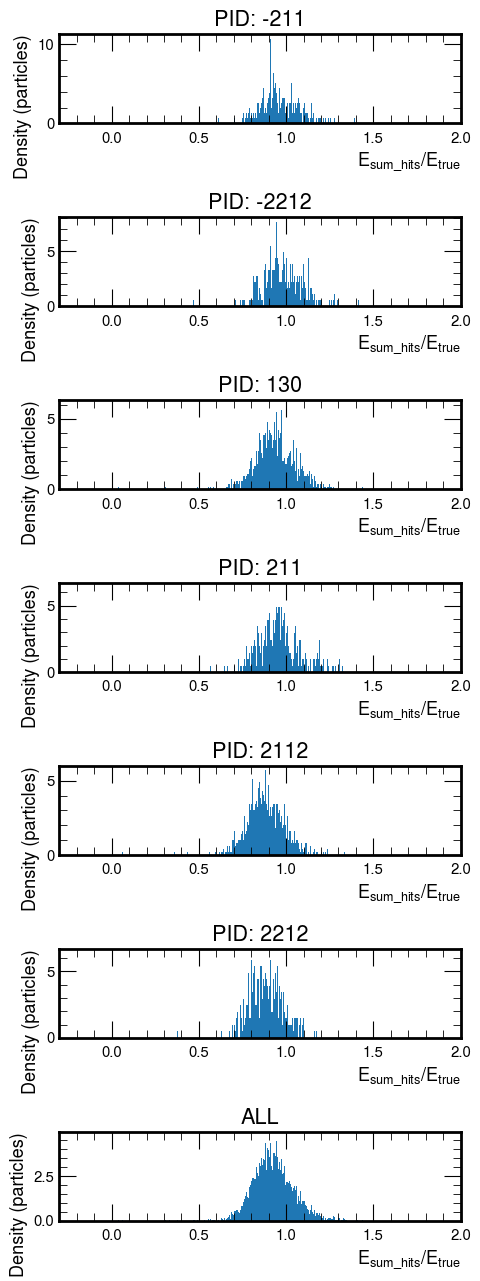

In [74]:
import matplotlib.pyplot as plt
all_ratios = {str(k): v for k, v in all_ratios.items()}
keys = sorted(list(all_ratios.keys()))
fig, ax = plt.subplots(len(keys), figsize=(5, 13))

for i in np.arange(len(keys)):
    ax[i].hist(all_ratios[keys[i]], bins=400, density=True)
    ax[i].set_xlim(-0.3, 2)
    ax[i].set_ylabel("Density (particles)")
    ax[i].set_xlabel(r"$E_{sum\_hits}/E_{true}$")
    #ax[i].set_title(f"{keys[i]} {len(all_ratios[keys[i]])} particles")
    if keys[i] == "ALL":
        ax[i].set_title("ALL")
    else:
        ax[i].set_title(f"PID: {keys[i]}")

fig.tight_layout()

#fig.savefig("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/new_dataset/energy_hist_corr1.pdf")
fig.show()
fig.savefig("/eos/home-g/gkrzmanc/summ_results_28092023/fracs_large_ds.pdf")

In [ ]:
fig.savefig("/eos/home-g/gkrzmanc/summ_results/1000ev_15_20_part_ds_not_removed1.pdf")

In [ ]:
# Energy vs number of hits plots...

import matplotlib as mpl
list(mpl.colormaps.keys())

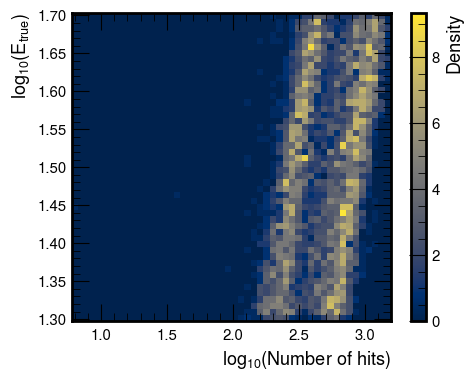

In [75]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.hist2d(np.log10(part_numb_of_hits), np.log10(part_energies), bins=50, density=True, cmap="cividis")
ax.set_xlabel("$log_{10} (Number\ of\ hits)$")
ax.set_ylabel("$log_{10} (E_{true})$")

# add colorbar
#im = ax.imshow(np.arange(100).reshape((10, 10)), cmap="viridis")
#cbar = fig.colorbar(im, ax=ax)
cbar = fig.colorbar(im[3], ax=ax)
cbar.set_label("Density")
#ax.yscale("log")
#ax.xscale("log")
fig.tight_layout()
fig.show()
#fig.savefig("/eos/home-g/gkrzmanc/summ_results_28092023/etrue_vs_nhits_100ev_unfiltered.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.hist2d((part_numb_of_hits), (frac_ecal_hits_all), bins=50, density=True, cmap="cividis")

ax.set_xlabel("$(Number\ of\ hits)$")
ax.set_ylabel("$(E_{ecal}/E_{ecal+hcal})$")
# add colorbar
#im = ax.imshow(np.arange(100).reshape((10, 10)), cmap="viridis")
#cbar = fig.colorbar(im, ax=ax)
cbar = fig.colorbar(im[3], ax=ax)
cbar.set_label("Density")
#ax.yscale("log")
#ax.xscale("log")
fig.tight_layout()
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(part_numb_of_hits, bins=50, density=True, histtype="step")
ax.set_xlabel("Number of hits")
ax.set_ylabel("Density (particles)")
fig.tight_layout()
fig.show()
#fig.savefig("/eos/home-g/gkrzmanc/summ_results_28092023/nhits-per-particle100ev_unfiltered.pdf")

In [73]:
unique_pids = list(set(part_pids))
pid_hits = {}


for pid in unique_pids:
    idx = [i for i in range(len(part_pids)) if part_pids[i] == pid]
    pid_hits[pid] = [part_numb_of_hits[i] for i in idx]

# plot pid_hits on the same histogram
fig, ax = plt.subplots(figsize=(4, 3))
for pid in unique_pids:
    ax.hist(pid_hits[pid], bins=50, density=True, histtype="step", label=pid)
ax.set_xlabel("Number of hits")
ax.set_ylabel("Density (particles)")
ax.legend()
fig.tight_layout()
fig.show()


TypeError: 'tuple' object is not callable

In [ ]:
# same hist as above, but separate the histograms for each pid
fig, ax = plt.subplots(len(unique_pids), figsize=(4, 10))

for i in range(len(unique_pids)):
    ax[i].hist(pid_hits[unique_pids[i]], bins=50, density=True, histtype="step", label=unique_pids[i])
    ax[i].set_xlabel("Number of hits")
    ax[i].set_ylabel("Density (particles)")
    ax[i].legend()
fig.tight_layout()
fig.show()


In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
ranges_energy = [(0, 25), (25, 35), (35, 50)]
for i , range1 in enumerate(ranges_energy):
    range_filt = [i for i in np.arange(len(part_energies)) if range1[0] <= part_energies[i] <= range1[1]]
    ax.hist(np.array(part_numb_of_hits)[range_filt], bins=50, density=True, histtype="step", label=str(range1))
ax.set_xlabel("Number of hits")
ax.set_ylabel("Density (particles)")
ax.legend()
fig.tight_layout()
fig.show()

In [ ]:
len(part_energies)

In [ ]:
len(frac_ecal_hits_all)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.hist2d((part_energies), (frac_ecal_hits_all), bins=50, density=True, cmap="cividis")

ax.set_xlabel("$E_{true}$")
ax.set_ylabel("$(E_{ecal}/E_{ecal+hcal})$")
# add colorbar
#im = ax.imshow(np.arange(100).reshape((10, 10)), cmap="viridis")
#cbar = fig.colorbar(im, ax=ax)
cbar = fig.colorbar(im[3], ax=ax)
cbar.set_label("Density")
#ax.yscale("log")
#ax.xscale("log")
fig.tight_layout()
fig.show()

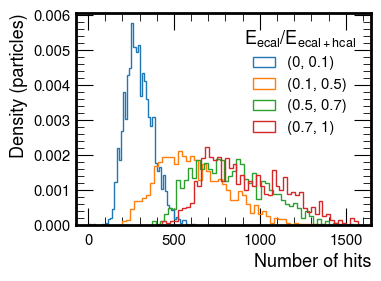

In [79]:
fig, ax = plt.subplots(figsize=(4,3))
ranges_ecal_frac = [(0, 0.1), (0.1, 0.5), (0.5,  0.7),  (0.7, 1)]
for i , range1 in enumerate(ranges_ecal_frac):
    range_filt = [i for i in np.arange(len(part_energies)) if range1[0] <= frac_ecal_hits_all[i] <= range1[1]]
    ax.hist(np.array(part_numb_of_hits)[range_filt], bins=50, density=True, histtype="step", label=str(range1))
ax.set_xlabel("Number of hits")
ax.set_ylabel("Density (particles)")
ax.legend(title="$E_{ecal}/E_{ecal+hcal}$")
fig.tight_layout()
fig.show()
fig.savefig("/eos/home-g/gkrzmanc/summ_results_28092023/ecal_frac_histograms_1.pdf")

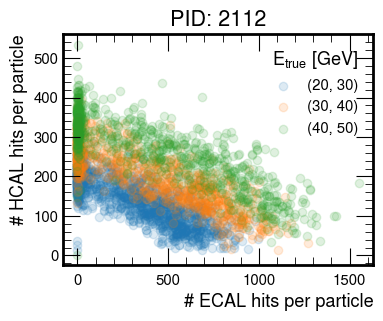

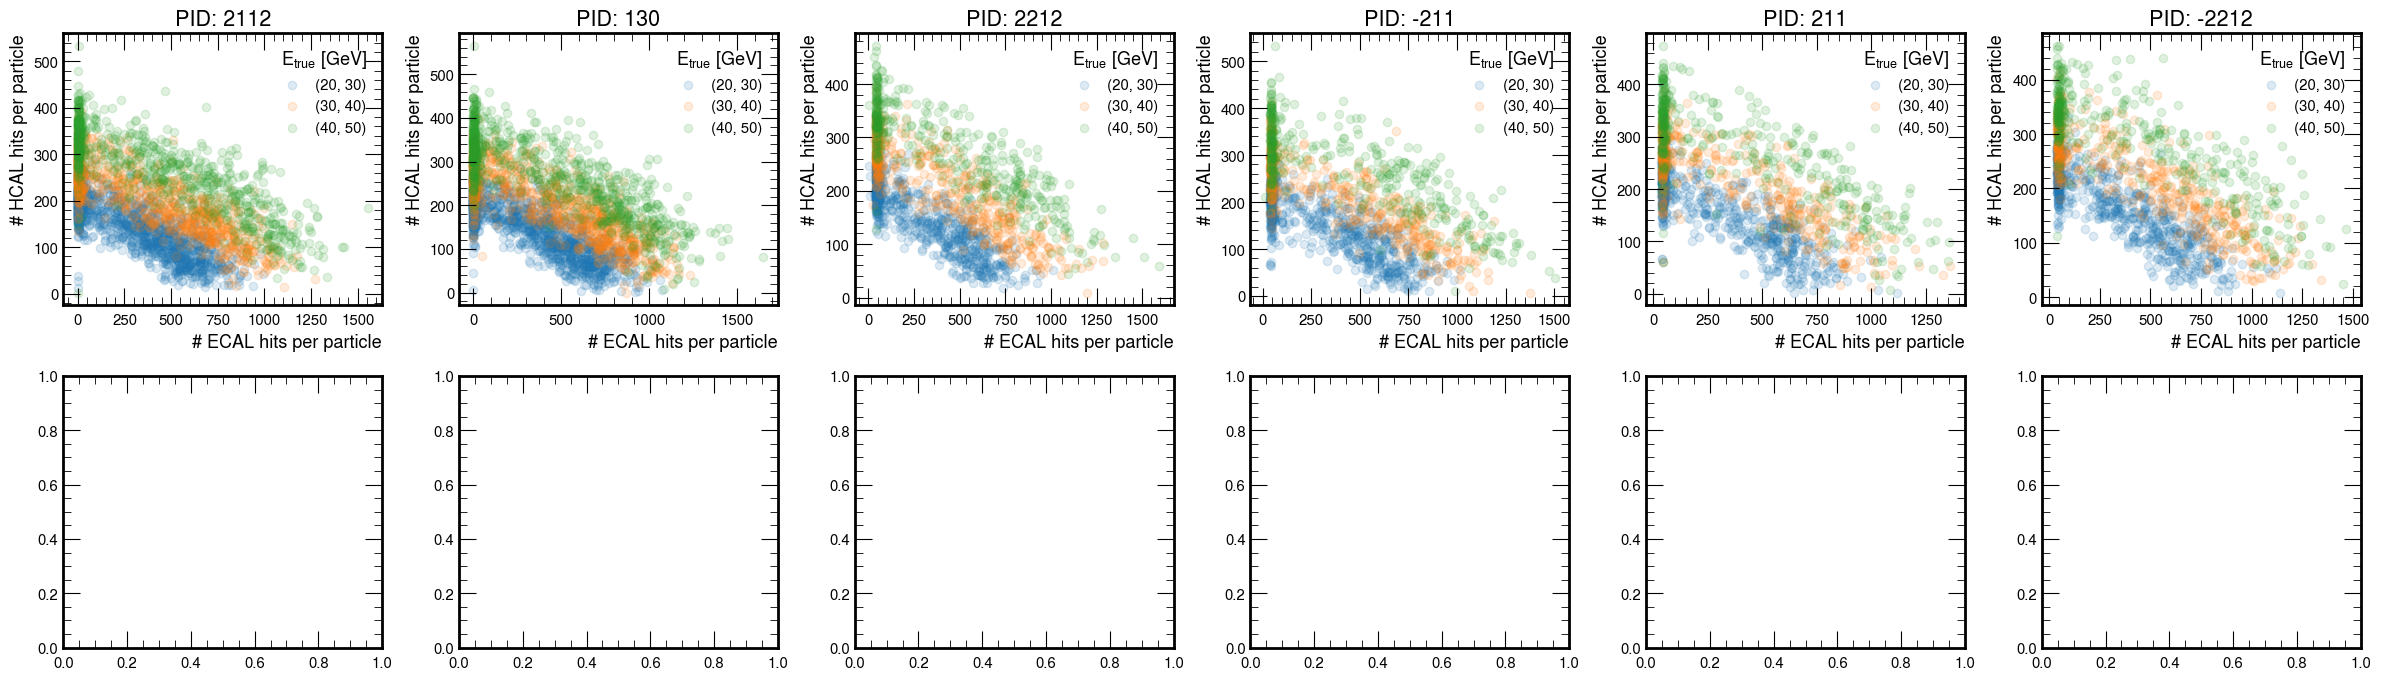

In [129]:

fig1, ax1 = plt.subplots(figsize=(4, 3))
ranges_energy = [(20, 30), (30, 40), (40, 50)]
unique_pids = list(set(part_pids))
num_ecal_hits_per_part_all
num_all_hits_per_part_all
fig, ax = plt.subplots(2, len(unique_pids), figsize=(24, 7))
for i1 , range1 in enumerate(ranges_energy):
    i = 0
    for j, partid in enumerate(unique_pids):
        range_filt =  (range1[0] <= np.array(part_energies)) & (np.array(part_energies) <= range1[1])
        pid_filt = range_filt & (np.array(part_pids) == partid)
        ax[i, j].scatter(np.array(num_ecal_hits_per_part_all)[pid_filt], np.array(num_all_hits_per_part_all)[pid_filt]-np.array(num_ecal_hits_per_part_all)[pid_filt], label=str(range1), alpha=0.15)
        ax[i, j].set_xlabel("# ECAL hits per particle")
        ax[i, j].set_ylabel("# HCAL hits per particle")
        ax[i, j].legend(title="$E_{true}$ [GeV]")
        ax[i, j].set_title("PID: " + str(partid))
        if i== 0 and j == 0:
            # do the same things to ax1
            ax1.scatter(np.array(num_ecal_hits_per_part_all)[pid_filt], np.array(num_all_hits_per_part_all)[pid_filt]-np.array(num_ecal_hits_per_part_all)[pid_filt], label=str(range1), alpha=0.15)
            ax1.set_xlabel("# ECAL hits per particle")
            ax1.set_ylabel("# HCAL hits per particle")
            ax1.legend(title="$E_{true}$ [GeV]")
            ax1.set_title("PID: " + str(partid))
fig.tight_layout()
fig.show()
fig.savefig("/eos/home-g/gkrzmanc/summ_results_28092023/ecal_vs_hcal_hits_per_pid_and_energy_range.pdf")

In [130]:
fig1.tight_layout()
fig1.show()
fig1.savefig("/eos/home-g/gkrzmanc/summ_results_28092023/ecal_vs_hcal_hits_per_pid_and_energy_range_2112.pdf")

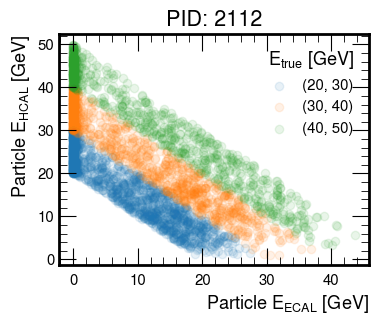

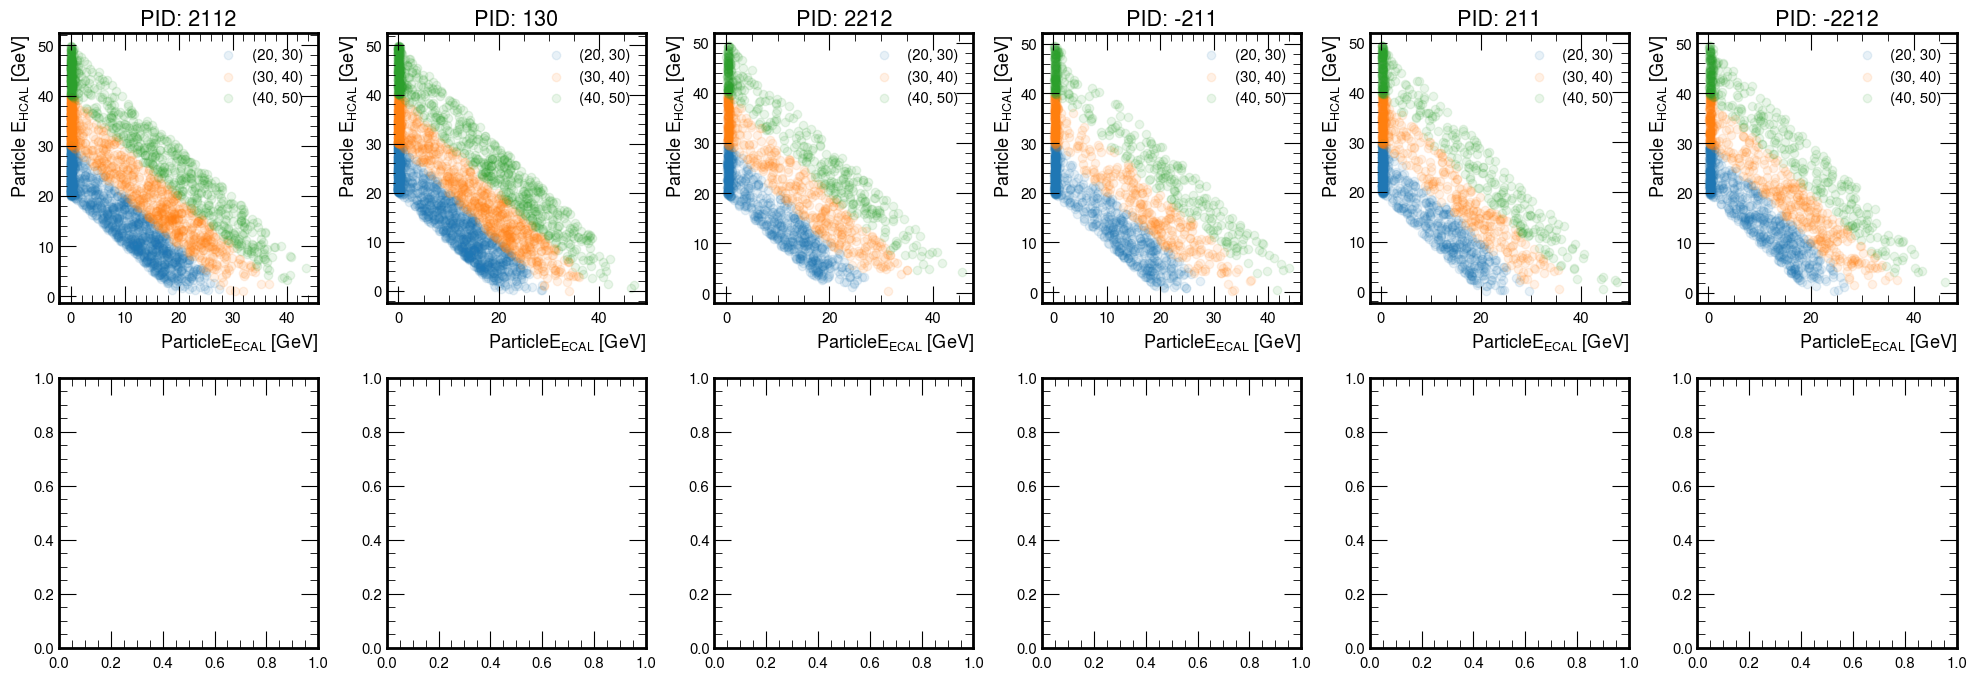

In [135]:

ranges_energy = [(20, 30), (30, 40), (40, 50)]
unique_pids = list(set(part_pids))

fig1, ax1 = plt.subplots(figsize=(4, 3))
fig, ax = plt.subplots(2, len(unique_pids), figsize=(20, 7))
for i1 , range1 in enumerate(ranges_energy):
    i = 0
    for j, partid in enumerate(unique_pids):
        range_filt =  (range1[0] <= np.array(part_energies)) & (np.array(part_energies) <= range1[1])
        pid_filt = range_filt & (np.array(part_pids) == partid)
        ax[i, j].scatter((np.array(frac_ecal_hits_all)*np.array(part_energies))[pid_filt], np.array(part_energies)[pid_filt]-(np.array(frac_ecal_hits_all)*np.array(part_energies))[pid_filt], label=str(range1), alpha=0.1)
        ax[i, j].set_xlabel("$Particle E_{ECAL}$ [GeV]")
        ax[i, j].set_ylabel("Particle $E_{HCAL}$ [GeV]")
        ax[i, j].legend()
        ax[i, j].set_title("PID: " + str(partid))
        if i==0 and j == 0:
            # do the same for ax1
            ax1.scatter((np.array(frac_ecal_hits_all)*np.array(part_energies))[pid_filt], np.array(part_energies)[pid_filt]-(np.array(frac_ecal_hits_all)*np.array(part_energies))[pid_filt], label=str(range1), alpha=0.1)
            ax1.set_xlabel("Particle $E_{ECAL}$ [GeV]")
            ax1.set_ylabel("Particle $E_{HCAL}$ [GeV]")
            ax1.legend(title="$E_{true}$ [GeV]")
            ax1.set_title("PID: " + str(partid))
fig.tight_layout()
fig.show()
fig.savefig("/eos/home-g/gkrzmanc/summ_results_28092023/ecal_vs_hcal_E_hits_per_pid_and_energy_range.pdf")

In [136]:
fig1.tight_layout()
fig1.show()
fig1.savefig("/eos/home-g/gkrzmanc/summ_results_28092023/ecal_vs_hcal_hits_per_pid_and_energy_range_2112_energies.pdf")